# Cancer Diagnosis Prediction

This notebook focuses on predicting whether a breast cancer tumor is malignant or benign based on features computed from a digitised image of a fine needle aspirate (FNA) of a breast mass. The dataset describes characteristics of cell nuclei present in the image, such as:

- **Radius**: Mean of distances from center to points on the perimeter.
- **Texture**: Standard deviation of gray-scale values.
- **Perimeter** and **Area**.
- **Smoothness**: Local variation in radius lengths.
- **Compactness**: Calculated as: (perimeter² / area - 1.0).
- **Concavity**: Severity of concave portions of the contour.
- **Concave Points**: Number of concave portions of the contour.
- **Symmetry** and **Fractal Dimension**: "Coastline approximation" - 1.

By analysing these features, the goal is to develop a machine learning pipeline to predict tumor diagnosis accurately.

## Load Dataset

### Import Necessary Libraries

In [19]:
import pandas as pd
import numpy as np
import joblib
import os
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

Preprocessing Steps:
1. Download dataset using kagglehub API
2. Convert ID column to string type for consistency
3. Remove empty/unnamed columns
4. Save cleaned dataset to local directory for model use

In [20]:
# Goes up one level from notebooks folder
os.makedirs('../data', exist_ok=True)

# Read and process as before
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
df = pd.read_csv(path + '/data.csv')
df['id'] = df['id'].astype(str)
df.set_index('id', inplace=True)
df = df.drop('Unnamed: 32', axis=1)

# Save to parent directory
output_path = '../data/cell-data.csv'
df.to_csv(output_path, index=False)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                 

Dataset Information:
- Source: UCI Machine Learning Repository
- Features: 30 numeric features computed from cell nuclei images
- Target: Binary classification (M = malignant, B = benign)
- Size: 569 instances

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.
They describe characteristics of the cell nuclei present in the image.

Feature Categories:
1. Radius (mean of distances from center to points on the perimeter)
2. Texture (standard deviation of gray-scale values)
3. Perimeter
4. Area
5. Smoothness (local variation in radius lengths)
6. Compactness (perimeter^2 / area - 1.0)
7. Concavity (severity of concave portions of the contour)
8. Concave points (number of concave portions of the contour)
9. Symmetry
10. Fractal dimension ("coastline approximation" - 1)

For each feature, three measurements are provided:
- Mean
- Standard error (SE)
- "Worst" or largest (mean of the three largest values)

In [22]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [23]:
# Basic statistics of numerical columns
print("\nNumerical Features Statistics:")
print(df.describe())


Numerical Features Statistics:
       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000  

In [24]:
# Distribution of target variable
print("\nTarget Variable Distribution:")
print(df['diagnosis'].value_counts(normalize=True))


Target Variable Distribution:
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


## Feature Engineering

### Correlation

We visualise the correlation matrix between features to:

1. Identify Multicollinearity:
   - Detect highly correlated features that might provide redundant information
   - Help prevent model overfitting by identifying features that could potentially be removed
   - Particularly important for this dataset as many features are derived from the same underlying measurements

2. Understand Feature Relationships:
   - Reveal patterns between different cell measurements (radius, texture, perimeter, etc.)
   - Show relationships between mean, SE, and "worst" measurements of the same characteristic
   - Help identify which features might be most informative for diagnosis

3. Guide Feature Selection:
   - Inform decisions about which features to keep or combine
   - Help identify groups of related features that might be candidates for dimensionality reduction
   - Support the creation of more interpretable and efficient models


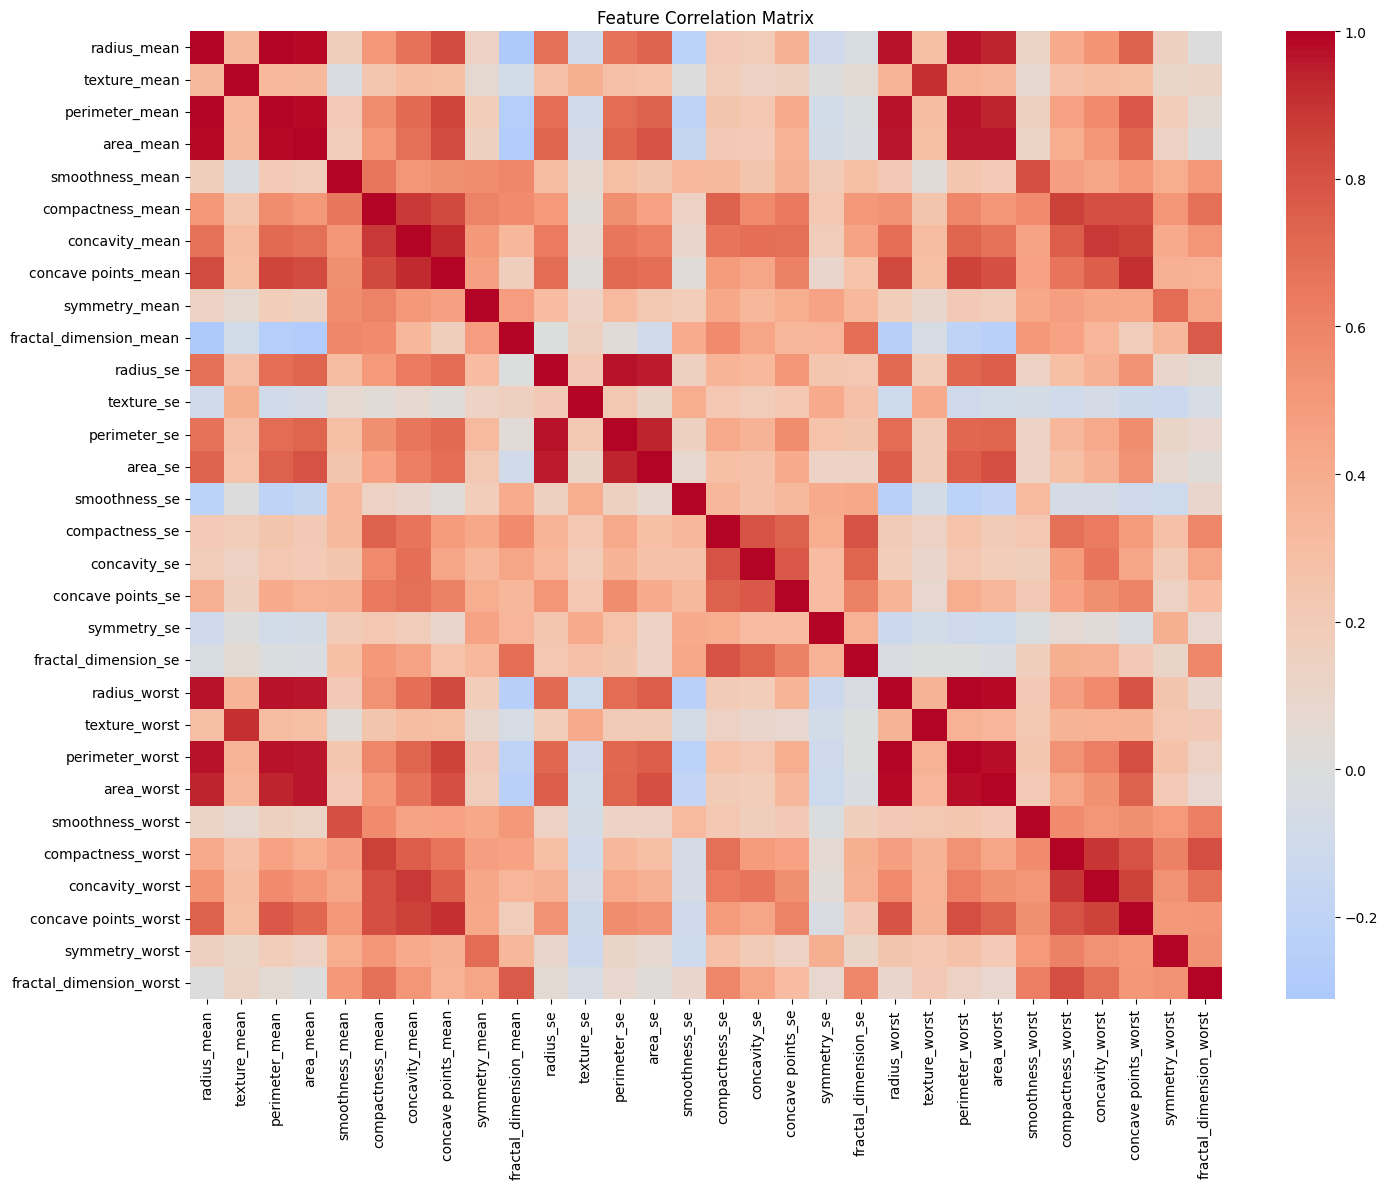

In [25]:
# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Create correlation matrix heatmap
plt.figure(figsize=(15, 12))
correlation_matrix = df.drop(['diagnosis'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()

# Save plot before showing it
plt.savefig('../results/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Identify highly correlated feature pairs
def get_highly_correlated_pairs(correlation_matrix, threshold=0.8):
    """
    Find pairs of features with correlation above threshold
    """
    highly_correlated = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                highly_correlated.append({
                    'feature1': correlation_matrix.columns[i],
                    'feature2': correlation_matrix.columns[j],
                    'correlation': correlation_matrix.iloc[i, j]
                })
    return pd.DataFrame(highly_correlated).sort_values('correlation', ascending=False)

# Perform the analysis
correlation_matrix = df.drop(['diagnosis'], axis=1).corr()

# Get highly correlated feature pairs
high_correlations = get_highly_correlated_pairs(correlation_matrix)
print("\nHighly Correlated Feature Pairs (correlation > 0.8):")
display(high_correlations)


Highly Correlated Feature Pairs (correlation > 0.8):


,feature1,feature2,correlation
0,radius_mean,perimeter_mean,0.997855
36,radius_worst,perimeter_worst,0.993708
1,radius_mean,area_mean,0.987357
7,perimeter_mean,area_mean,0.986507
37,radius_worst,area_worst,0.984015
38,perimeter_worst,area_worst,0.977578
30,radius_se,perimeter_se,0.972794
10,perimeter_mean,perimeter_worst,0.970387
3,radius_mean,radius_worst,0.969539
9,perimeter_mean,radius_worst,0.969476


In [27]:
# Calculate correlation with target
def get_target_correlations(df):
    """
    Calculate correlation of features with the diagnosis
    """
    # Convert diagnosis to numeric (0 for 'B', 1 for 'M')
    diagnosis_numeric = (df['diagnosis'] == 'M').astype(int)

    # Calculate correlation with each feature
    correlations = []
    for column in df.drop(['diagnosis'], axis=1).columns:
        correlation = df[column].corr(diagnosis_numeric)
        correlations.append({
            'feature': column,
            'correlation_with_diagnosis': abs(correlation)
        })
    return pd.DataFrame(correlations).sort_values('correlation_with_diagnosis', ascending=False)

# Get feature correlations with diagnosis
target_correlations = get_target_correlations(df)
print("\nFeature Correlations with Diagnosis (absolute values):")
display(target_correlations)


Feature Correlations with Diagnosis (absolute values):


,feature,correlation_with_diagnosis
27,concave points_worst,0.793566
22,perimeter_worst,0.782914
7,concave points_mean,0.776614
20,radius_worst,0.776454
2,perimeter_mean,0.742636
23,area_worst,0.733825
0,radius_mean,0.730029
3,area_mean,0.708984
6,concavity_mean,0.696360
26,concavity_worst,0.659610


In [28]:
# Group features by measurement type
def group_related_features(df):
    """
    Group features by their base measurement (radius, texture, etc.)
    """
    feature_groups = {}
    base_measurements = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
                        'compactness', 'concavity', 'concave points', 'symmetry',
                        'fractal_dimension']

    for base in base_measurements:
        related_features = [col for col in df.columns if base in col]
        feature_groups[base] = related_features

    return feature_groups

# Group related features
feature_groups = group_related_features(df)
print("\nFeature Groups:")
for base, features in feature_groups.items():
    print(f"\n{base.capitalize()} measurements:")
    print(features)


Feature Groups:

Radius measurements:
['radius_mean', 'radius_se', 'radius_worst']

Texture measurements:
['texture_mean', 'texture_se', 'texture_worst']

Perimeter measurements:
['perimeter_mean', 'perimeter_se', 'perimeter_worst']

Area measurements:
['area_mean', 'area_se', 'area_worst']

Smoothness measurements:
['smoothness_mean', 'smoothness_se', 'smoothness_worst']

Compactness measurements:
['compactness_mean', 'compactness_se', 'compactness_worst']

Concavity measurements:
['concavity_mean', 'concavity_se', 'concavity_worst']

Concave points measurements:
['concave points_mean', 'concave points_se', 'concave points_worst']

Symmetry measurements:
['symmetry_mean', 'symmetry_se', 'symmetry_worst']

Fractal_dimension measurements:
['fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst']


In [29]:
# Calculate mean correlation within groups
print("\nMean Absolute Correlation within Feature Groups:")
for base, features in feature_groups.items():
    # Example: base might be 'radius',
    # features would be ['radius_mean', 'radius_se', 'radius_worst']

    # correlation_matrix.loc[features, features] creates a sub-matrix of
    # correlations just for these related features

    # For radius features, it creates a 3x3 matrix like:
    #              radius_mean  radius_se  radius_worst
    # radius_mean      1.0        0.3         0.7
    # radius_se        0.3        1.0         0.4
    # radius_worst     0.7        0.4         1.0

    # .abs() takes absolute values of correlations
    # first .mean() averages each row
    # second .mean() averages those averages
    group_corr = correlation_matrix.loc[features, features].abs().mean().mean()
    print(f"{base}: {group_corr:.3f}")


Mean Absolute Correlation within Feature Groups:
radius: 0.859
texture: 0.713
perimeter: 0.863
area: 0.905
smoothness: 0.656
compactness: 0.841
concavity: 0.831
concave points: 0.806
symmetry: 0.675
fractal_dimension: 0.788


**Feature Selection Strategy**

If two features are highly correlated (>0.9), we can keep the feature that has stronger predictive power for diagnosis. For example, if 'radius_mean' and 'perimeter_mean' are highly correlated, we keep whichever has higher correlation with malignant/benign outcome

The final output provides:
- List of most important features for diagnosis.
- List of features that could be removed without significant loss of information
This supports building a more efficient model with reduced multicollinearity.

In [30]:
# Feature selection recommendations
high_importance_features = target_correlations[target_correlations['correlation_with_diagnosis'] > 0.5]['feature'].tolist()

# Identify features to potentially remove due to high correlation
features_to_consider_removing = []
correlation_threshold = 0.9
for _, row in high_correlations[high_correlations['correlation'] > correlation_threshold].iterrows():
    # Keep the feature with higher correlation to diagnosis
    feature1_corr = target_correlations[target_correlations['feature'] == row['feature1']]['correlation_with_diagnosis'].iloc[0]
    feature2_corr = target_correlations[target_correlations['feature'] == row['feature2']]['correlation_with_diagnosis'].iloc[0]

    if feature1_corr > feature2_corr:
        features_to_consider_removing.append(row['feature2'])
    else:
        features_to_consider_removing.append(row['feature1'])

features_to_consider_removing = list(set(features_to_consider_removing))

print("\nFeature Selection Recommendations:")
print("\nHighly Important Features (correlation with diagnosis > 0.5):")
print(high_importance_features)
print("\nFeatures to Consider Removing (due to high correlation):")
print(features_to_consider_removing)


Feature Selection Recommendations:

Highly Important Features (correlation with diagnosis > 0.5):
['concave points_worst', 'perimeter_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst', 'compactness_mean', 'compactness_worst', 'radius_se', 'perimeter_se', 'area_se']

Features to Consider Removing (due to high correlation):
['perimeter_mean', 'texture_mean', 'concave points_mean', 'area_se', 'radius_worst', 'radius_mean', 'perimeter_se', 'area_worst', 'concavity_mean', 'area_mean']


**[insert comparison of model trained on original dataset vs reduced dataset]**

### Box Plot Analysis and Distribution Interpretation

1. Basic Distribution Statistics:
   - Q1 (25th percentile): Lower edge of box
   - Q3 (75th percentile): Upper edge of box
   - IQR (Interquartile Range) = Q3 - Q1: Height of box
   - Median: Line inside box
   - Whiskers: Extend to last point within 1.5 * IQR of Q1 and Q3
   
2. Outlier Detection:
   - Lower bound = Q1 - 1.5 * IQR
   - Upper bound = Q3 + 1.5 * IQR
   - Points beyond these bounds are considered outliers

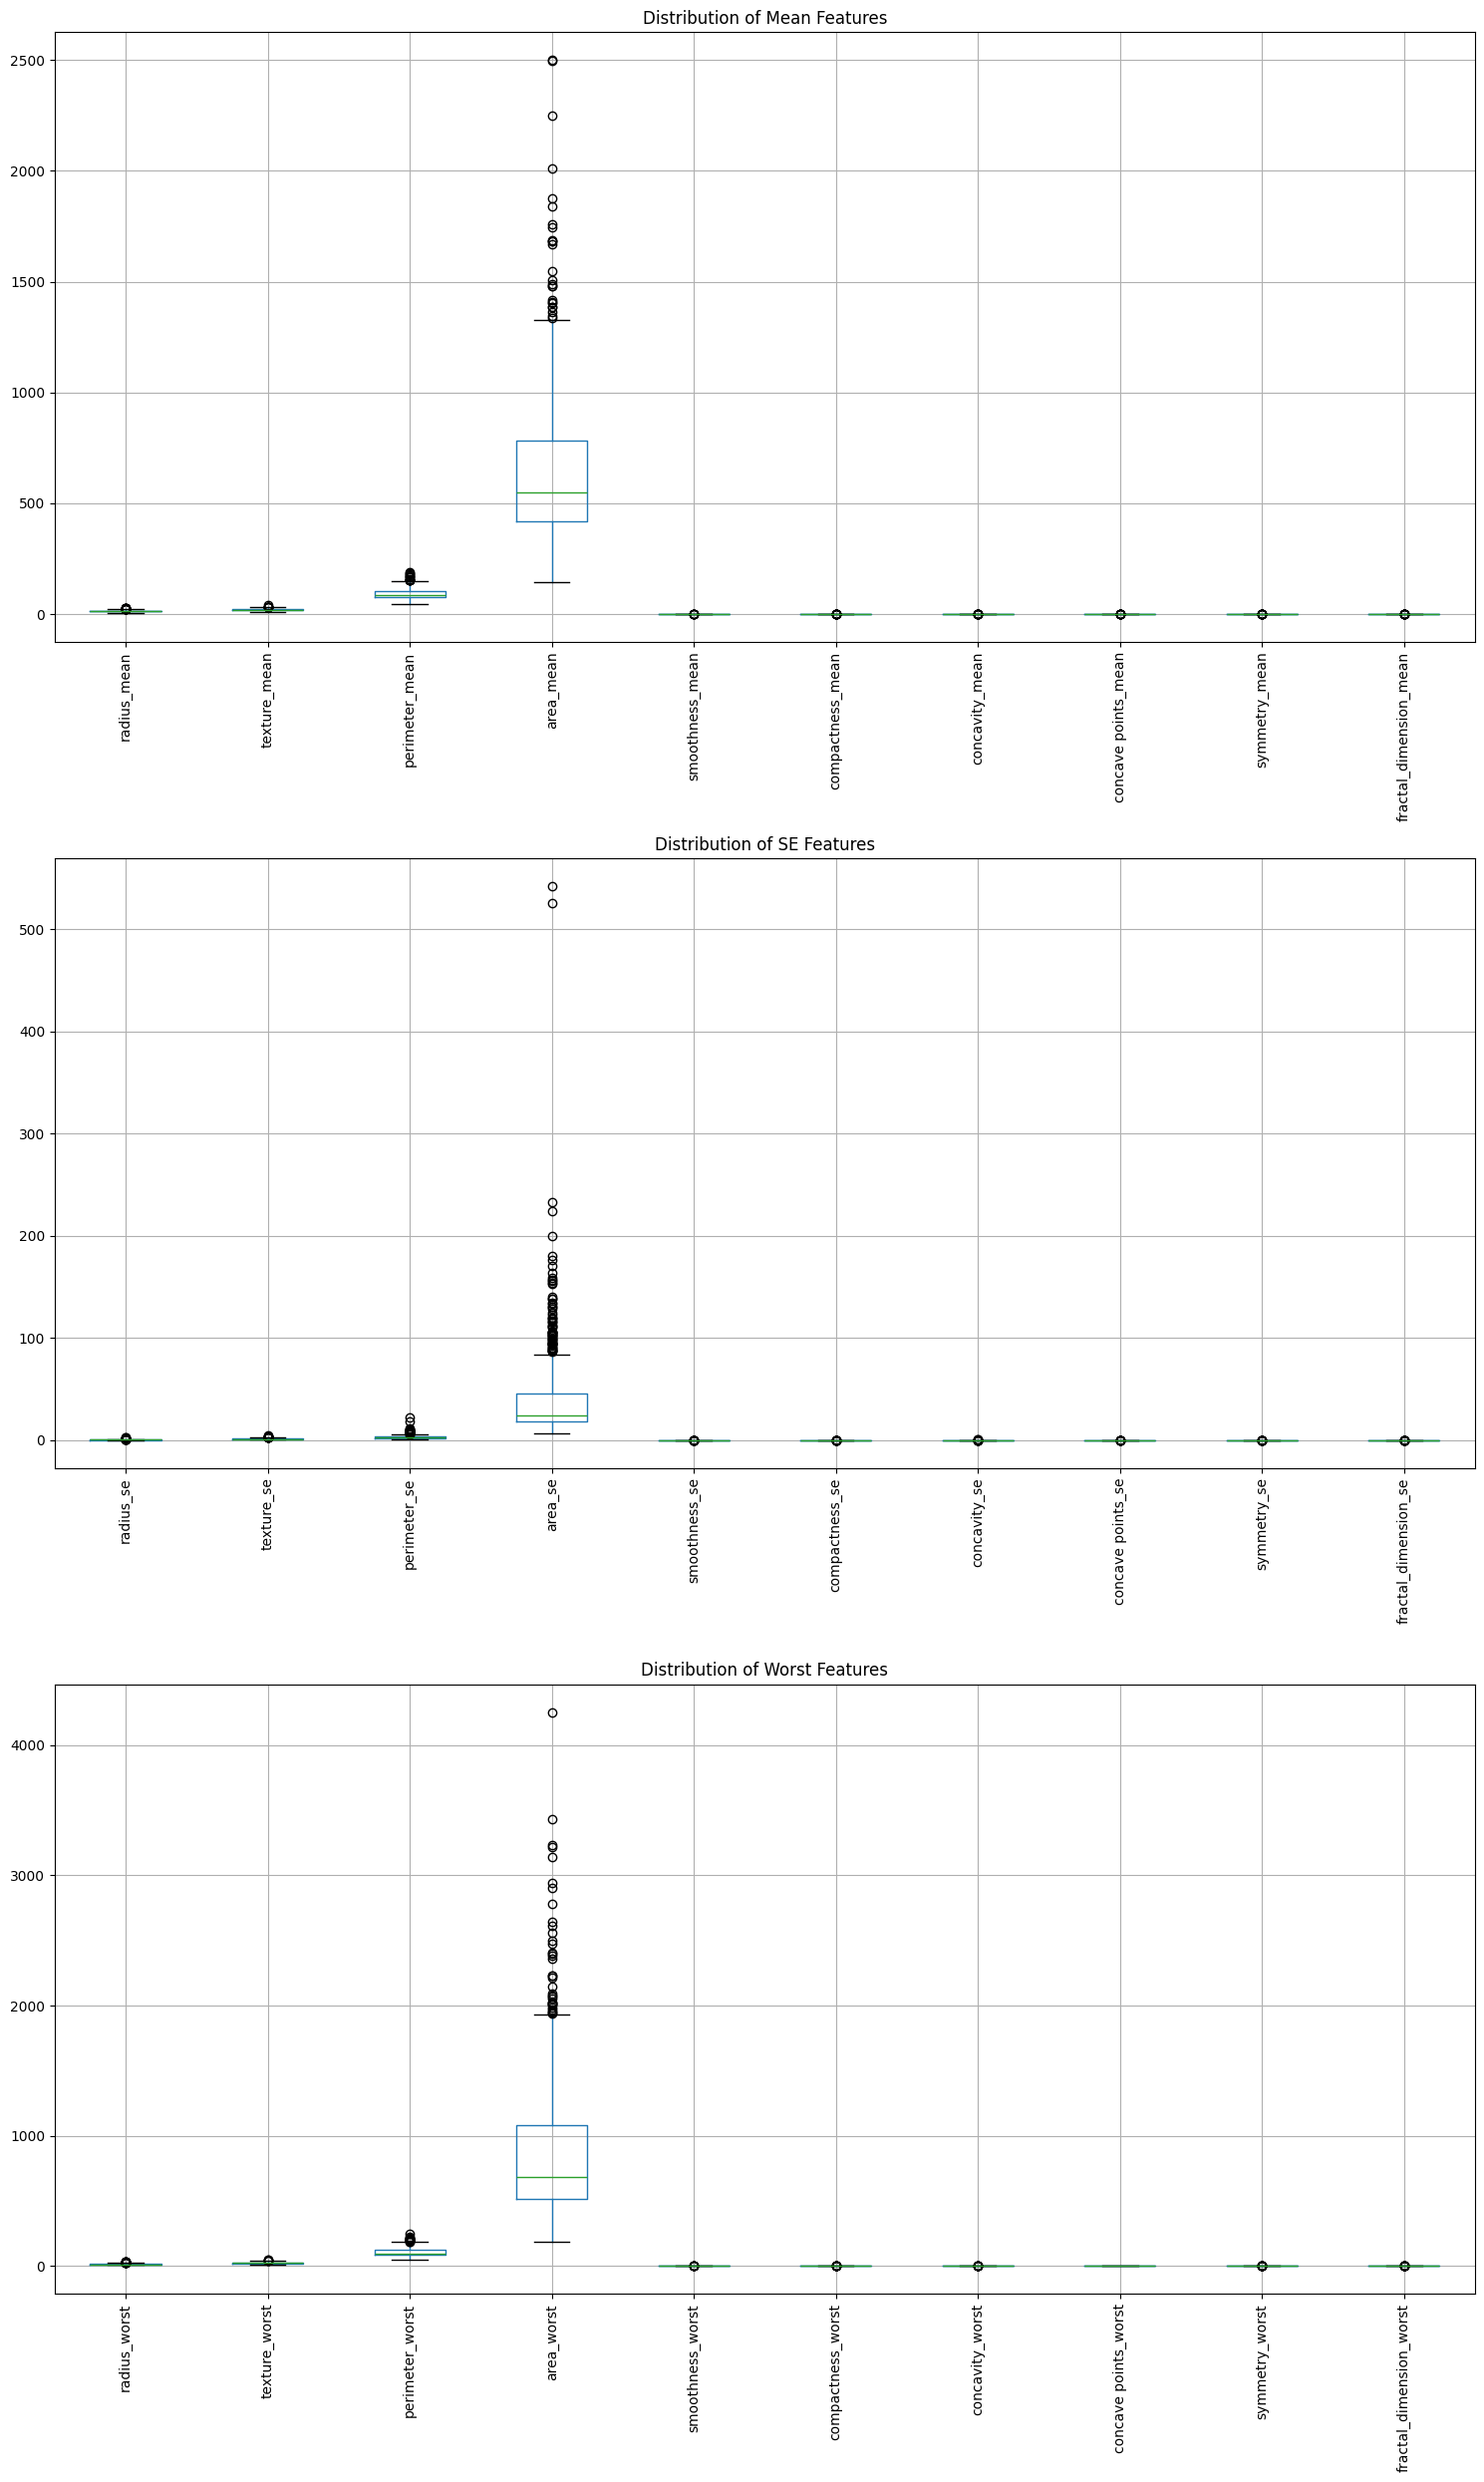

In [31]:
# Create separate box plots for mean, worst, and se features
plt.figure(figsize=(15, 25))

# Mean features
plt.subplot(3, 1, 1)
mean_features = [col for col in df.columns if 'mean' in col]
df.boxplot(column=mean_features)
plt.xticks(rotation=90)
plt.title('Distribution of Mean Features')

# SE features
plt.subplot(3, 1, 2)
se_features = [col for col in df.columns if '_se' in col]
df.boxplot(column=se_features)
plt.xticks(rotation=90)
plt.title('Distribution of SE Features')

# Worst features
plt.subplot(3, 1, 3)
worst_features = [col for col in df.columns if 'worst' in col]
df.boxplot(column=worst_features)
plt.xticks(rotation=90)
plt.title('Distribution of Worst Features')

plt.tight_layout()

# Save plot before showing it
plt.savefig('../results/boxplot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

1. Outlier Detection:
   - Code calculates percentage of points that are outliers.

2. Variation Measures:
   - Standard Deviation (std): Measures spread of all data points
   - IQR: Robust measure of spread, less sensitive to outliers
   - High std + high IQR: Feature has wide spread
   - Low std + low IQR: Feature might be redundant

3. Feature Selection Criteria:
   - High Outlier Percentage (>10%):
     May indicate noisy or problematic features
   - Low Variation (< 0.1 * median std):
     May indicate feature doesn't provide much discriminative power
   - SE vs Mean/Worst Comparison:
     If SE variation < 30% of mean/worst, SE feature might be redundant

4. Measurement Type Comparison:
   - Compares variation across mean, SE, and worst for each measurement
   - Helps identify which measurement type (mean/SE/worst) is most informative
   - SE measurements often show less variation, making them candidates for removal

5. Final Recommendations:
   - Suggests dropping features with very low variation
   - Identifies redundant SE measurements
   - Creates list of features that might not contribute significantly to model

In [32]:
# Analyze outliers and spread for each feature type
def analyze_feature_distributions(df, feature_group_name, features):
    """
    Analyze distribution characteristics of feature groups
    """
    stats = []
    for col in features:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        outliers = df[(df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))][col].count()

        stats.append({
            'feature': col,
            'std': df[col].std(),
            'iqr': iqr,
            'outlier_count': outliers,
            'outlier_percentage': (outliers / len(df)) * 100
        })

    stats_df = pd.DataFrame(stats)
    print(f"\n{feature_group_name} Features Analysis:")
    display(stats_df.sort_values('outlier_percentage', ascending=False))
    return stats_df

# Analyze each feature group
mean_stats = analyze_feature_distributions(df, "Mean", mean_features)
se_stats = analyze_feature_distributions(df, "SE", se_features)
worst_stats = analyze_feature_distributions(df, "Worst", worst_features)

# Identify features with high outlier percentages or low variation
outlier_threshold = 10  # Features with > 10% outliers
variation_threshold = df[mean_features + se_features + worst_features].std().median() * 0.1  # Features with very low variation

features_to_consider_dropping = []

# Check for features with high outliers
high_outlier_features = pd.concat([mean_stats, se_stats, worst_stats])[
    pd.concat([mean_stats, se_stats, worst_stats])['outlier_percentage'] > outlier_threshold
]['feature'].tolist()

# Check for features with low variation
low_variation_features = df[mean_features + se_features + worst_features].columns[
    df[mean_features + se_features + worst_features].std() < variation_threshold
].tolist()

# Compare variations between mean, SE, and worst for same measurements
measurement_comparisons = {}
base_measurements = ['radius', 'texture', 'perimeter', 'area', 'smoothness',
                    'compactness', 'concavity', 'concave points', 'symmetry',
                    'fractal_dimension']

for base in base_measurements:
    mean_var = df[f'{base}_mean'].std() if f'{base}_mean' in df.columns else 0
    se_var = df[f'{base}_se'].std() if f'{base}_se' in df.columns else 0
    worst_var = df[f'{base}_worst'].std() if f'{base}_worst' in df.columns else 0

    measurement_comparisons[base] = {
        'mean_var': mean_var,
        'se_var': se_var,
        'worst_var': worst_var
    }

print("\nFeature Selection Recommendations based on Distributions:")
print("\nFeatures with high outlier percentage (>10%):")
print(high_outlier_features)

print("\nFeatures with low variation:")
print(low_variation_features)

print("\nVariation Comparison for Each Measurement Type:")
for base, vars in measurement_comparisons.items():
    print(f"\n{base}:")
    print(f"Mean variation: {vars['mean_var']:.3f}")
    print(f"SE variation: {vars['se_var']:.3f}")
    print(f"Worst variation: {vars['worst_var']:.3f}")

# Final recommendations
print("\nFinal Recommendations:")
print("Consider dropping these features based on distribution analysis:")
redundant_features = []

for base in base_measurements:
    vars = measurement_comparisons[base]
    # If SE variation is much lower than mean and worst, consider dropping SE
    if vars['se_var'] < 0.3 * vars['mean_var'] and vars['se_var'] < 0.3 * vars['worst_var']:
        redundant_features.append(f"{base}_se")

# Add features with very low variation
redundant_features.extend(low_variation_features)

# Remove duplicates and sort
redundant_features = sorted(list(set(redundant_features)))
print(redundant_features)


Mean Features Analysis:


,feature,std,iqr,outlier_count,outlier_percentage
3,area_mean,351.914129,362.40000,25,4.393673
6,concavity_mean,0.079720,0.10114,18,3.163445
5,compactness_mean,0.052813,0.06548,16,2.811951
8,symmetry_mean,0.027414,0.03380,15,2.636204
9,fractal_dimension_mean,0.007060,0.00842,15,2.636204
0,radius_mean,3.524049,4.08000,14,2.460457
2,perimeter_mean,24.298981,28.93000,13,2.284710
7,concave points_mean,0.038803,0.05369,10,1.757469
1,texture_mean,4.301036,5.63000,7,1.230228
4,smoothness_mean,0.014064,0.01893,6,1.054482



SE Features Analysis:


,feature,std,iqr,outlier_count,outlier_percentage
3,area_se,45.491006,27.340000,65,11.423550
0,radius_se,0.277313,0.246500,38,6.678383
2,perimeter_se,2.021855,1.751000,38,6.678383
4,smoothness_se,0.003003,0.002977,30,5.272408
9,fractal_dimension_se,0.002646,0.002310,28,4.920914
5,compactness_se,0.017908,0.019370,28,4.920914
8,symmetry_se,0.008266,0.008320,27,4.745167
6,concavity_se,0.030186,0.026960,22,3.866432
1,texture_se,0.551648,0.640100,20,3.514938
7,concave points_se,0.006170,0.007072,19,3.339192



Worst Features Analysis:


,feature,std,iqr,outlier_count,outlier_percentage
3,area_worst,569.356993,568.70000,35,6.151142
9,fractal_dimension_worst,0.018061,0.02062,24,4.217926
8,symmetry_worst,0.061867,0.06750,23,4.042179
0,radius_worst,4.833242,5.78000,17,2.987698
5,compactness_worst,0.157336,0.19190,16,2.811951
2,perimeter_worst,33.602542,41.29000,15,2.636204
6,concavity_worst,0.208624,0.26840,12,2.108963
4,smoothness_worst,0.022832,0.02940,7,1.230228
1,texture_worst,6.146258,8.64000,5,0.878735
7,concave points_worst,0.065732,0.09647,0,0.000000



Feature Selection Recommendations based on Distributions:

Features with high outlier percentage (>10%):
['area_se']

Features with low variation:
['fractal_dimension_mean', 'smoothness_se', 'concave points_se', 'fractal_dimension_se']

Variation Comparison for Each Measurement Type:

radius:
Mean variation: 3.524
SE variation: 0.277
Worst variation: 4.833

texture:
Mean variation: 4.301
SE variation: 0.552
Worst variation: 6.146

perimeter:
Mean variation: 24.299
SE variation: 2.022
Worst variation: 33.603

area:
Mean variation: 351.914
SE variation: 45.491
Worst variation: 569.357

smoothness:
Mean variation: 0.014
SE variation: 0.003
Worst variation: 0.023

compactness:
Mean variation: 0.053
SE variation: 0.018
Worst variation: 0.157

concavity:
Mean variation: 0.080
SE variation: 0.030
Worst variation: 0.209

concave points:
Mean variation: 0.039
SE variation: 0.006
Worst variation: 0.066

symmetry:
Mean variation: 0.027
SE variation: 0.008
Worst variation: 0.062

fractal_dimensio

## Model Training

In [33]:
# Separate features and target
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

**Random Forest Working Principle**:

- Creates multiple decision trees (100 or 200 in this case)
- Each tree:
  - a. Gets a random subset of the data (bootstrap sampling)
  - b. At each split, considers a random subset of features
  - c. Makes its own prediction (0 or 1)
- Final prediction is majority vote from all trees

In [34]:
# Convert target to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y) # 'M' -> 1, 'B' -> 0

# Split the data, stratify=y ensures proportional split of malignant/benign cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create preprocessing and modeling pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), # StandardScaler standardises features to mean=0, std=1
    ('classifier', RandomForestClassifier(random_state=42)) # Combines multiple decision trees
])

# Define hyperparameters for grid search
param_grid = {
    'classifier__n_estimators': [100, 200], # Number of trees in the forest
    'classifier__max_depth': [10, 20, None], # Maximum depth of each tree
    'classifier__min_samples_split': [2, 5], # Minimum samples required to split node
    'classifier__min_samples_leaf': [1, 2] # Minimum samples required in leaf node
}

# Perform grid search with cross-validation
# Tests all combinations of hyperparameters
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Cross-Validation Score: 0.9905572755417957


**Why cross-validation?**


For a 650 x 30 dataset, cross-validation is the best choice because:

1. Sample Size Per Split:
  - With a validation set approach (60/20/20):
    - 390 training samples, 130 validation samples, 130 test samples
    - Example validation scores might be:
    
        Model Config A: 0.85 (but could be anywhere from 0.80-0.90 due to random split)
        
        Model Config B: 0.87 (but could be anywhere from 0.82-0.92 due to random split)

  - With 5-fold CV:
    - 520 samples for training/validation
    - Each fold uses ~416 samples for training
    - Example scores for same configs:
        
        Model Config A: 0.83, 0.86, 0.84, 0.87, 0.85 (avg: 0.85 ± 0.015)
        
        Model Config B: 0.84, 0.85, 0.84, 0.85, 0.84 (avg: 0.844 ± 0.005)

  **Now we can be more confident Config A is actually better.**

2. Feature to Sample Ratio:
  - You have 30 features
  - Rule of thumb: want at least 10 samples per feature for stable estimates
  - Validation split gives only: 390/30 = 13 samples per feature
  - CV gives: 416/30 = ~14 samples per feature, but with 5 different evaluations

In [35]:
# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Evaluate the model
best_model = grid_search.best_estimator_  # Extracts the model with best performing hyperparameters
y_pred = best_model.predict(X_test)  # Makes binary predictions (Benign (0) or Malignant (1))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# [:, 1] selects probability of Malignant class
# Example: 0.92 means 92% confidence in Malignant diagnosis

# Save the model in models directory
model_path = '../app/backend/models/cancer_diagnosis_model.joblib'
joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Model saved to: ../app/backend/models/cancer_diagnosis_model.joblib

Classification Report:
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



**ROC Curve**: True Positive Rate (TPR) vs False Positive Rate (FPR) at different classification thresholds.

**AUC** measures the entire area underneath the ROC curve.

**ROC-AUC Score:** The probability that a randomly chosen positive case receives a higher score than a randomly chosen negative case.

**Example: Cancer Diagnosis Model**

Consider a model that predicts cancer diagnosis with the following ROC-AUC scores:

`ROC-AUC = 1.0 (Perfect)`

Interpretation: If you select any patient with cancer and any patient without cancer, 100% of the time the model will give the cancer patient a higher risk score.

Example:

Patient A (has cancer): predicted risk 0.9
Patient B (has cancer): predicted risk 0.8
Patient C (no cancer): predicted risk 0.2

Patient D (no cancer): predicted risk 0.1
Every cancer patient gets a higher score than every non-cancer patient


---



`ROC-AUC = 0.9 (Excellent)`

Interpretation: If you select any patient with cancer and any patient without cancer, 90% of the time the model will give the cancer patient a higher risk score.

Example:

Patient A (has cancer): predicted risk 0.9
Patient B (has cancer): predicted risk 0.7
Patient C (no cancer): predicted risk 0.8
Patient D (no cancer): predicted risk 0.1

Most cancer patients get higher scores, but there are some overlaps


---



`ROC-AUC = 0.75 (Good)`

Interpretation: If you select any patient with cancer and any patient without cancer, 75% of the time the model will give the cancer patient a higher risk score.

Example:

Patient A (has cancer): predicted risk 0.8
Patient B (has cancer): predicted risk 0.6
Patient C (no cancer): predicted risk 0.7
Patient D (no cancer): predicted risk 0.3

There's more overlap between the scores of positive and negative cases


---



`ROC-AUC = 0.5 (Random)`

Interpretation: If you select any patient with cancer and any patient without cancer, 50% of the time the model will give the cancer patient a higher risk score (equivalent to random guessing).

Example:

Patient A (has cancer): predicted risk 0.6
Patient B (has cancer): predicted risk 0.3
Patient C (no cancer): predicted risk 0.7
Patient D (no cancer): predicted risk 0.2

No clear pattern in how the model ranks positive vs negative cases

In [36]:
# Calculate and print ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc) # 1.0 perfect, 0.5 is random (flipping a coin), less than 0.5 is worse than random.

ROC-AUC Score: 0.9950396825396826


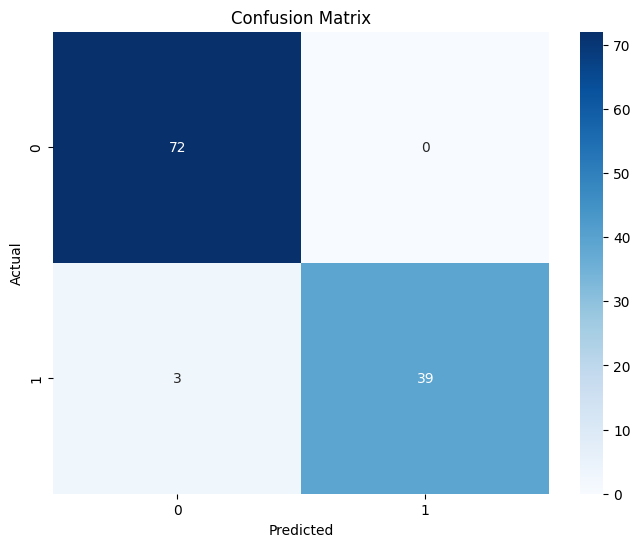

In [37]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save plot before showing it
plt.savefig('../results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Random Forests calculate feature importance through a measure called "Mean Decrease in Impurity" (MDI) or "Gini importance".

At each split node, the algorithm calculates how much that split improved the purity of the data (reduced Gini impurity or entropy). This improvement is weighted by the number of samples that reach that node. Each feature gets credit for the improvements in purity for all splits where it was used.

`Feature Importance = (∑ (improvement in purity × samples at node)) / (total samples)`

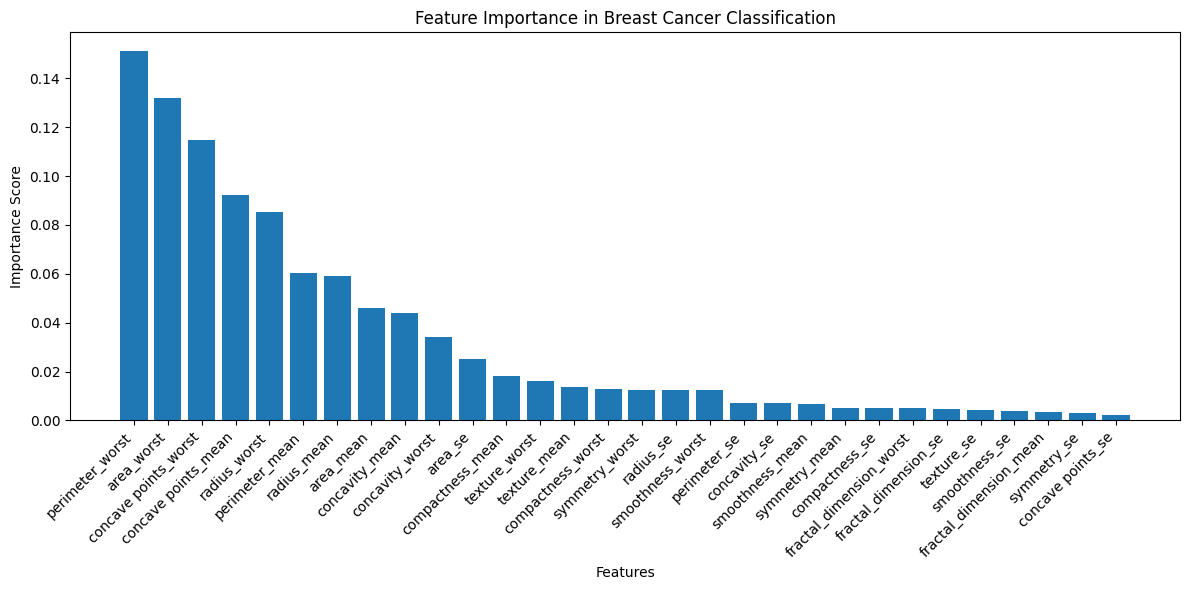


Top 5 Most Important Features:
                 feature  importance
22       perimeter_worst    0.151233
23            area_worst    0.132112
27  concave points_worst    0.114815
7    concave points_mean    0.092151
20          radius_worst    0.085412


In [38]:
# Get feature importance scores
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = X.columns

# Create DataFrame of feature importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

# Create feature importance plot
plt.figure(figsize=(12, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance in Breast Cancer Classification')
plt.tight_layout()

# Save plot before showing it
plt.savefig('../results/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top 5 most important features
print("\nTop 5 Most Important Features:")
print(importance_df.head())

## Additional Model Validation and Analysis

### 1. Learning Curves Analysis

Learning curves analyse how an algorithm's performance changes with different amounts of training data, plotting both training and cross-validation scores. Rather than evaluating your specific tuned model, it tests the basic Random Forest algorithm by training many fresh versions with increasing data sizes. In your case, the flat training score of 1.0 and high CV score (0.985-0.99) shows that Random Forests tend to perfectly memorise training data while still generalising very well to new data on this problem. This pattern helps diagnose if your modeling approach is fundamentally sound, if you need more data, and whether you're dealing with overfitting or underfitting - all independent of the specific hyperparameters you eventually choose.

`train_sizes = np.linspace(0.1, 1.0, 10)` creates 10 equally spaced fractions of your training data. If you have 520 training samples (after 20% test split from 650): 0.1 = 52 samples, 0.2 = 104 samples, 0.3 = 156 samples ...and so on

For each of these sample sizes:

1. Randomly select that many samples from training data
2. Use 5-fold CV to:
  - Train model on 80% of those samples
  - Test on remaining 20%

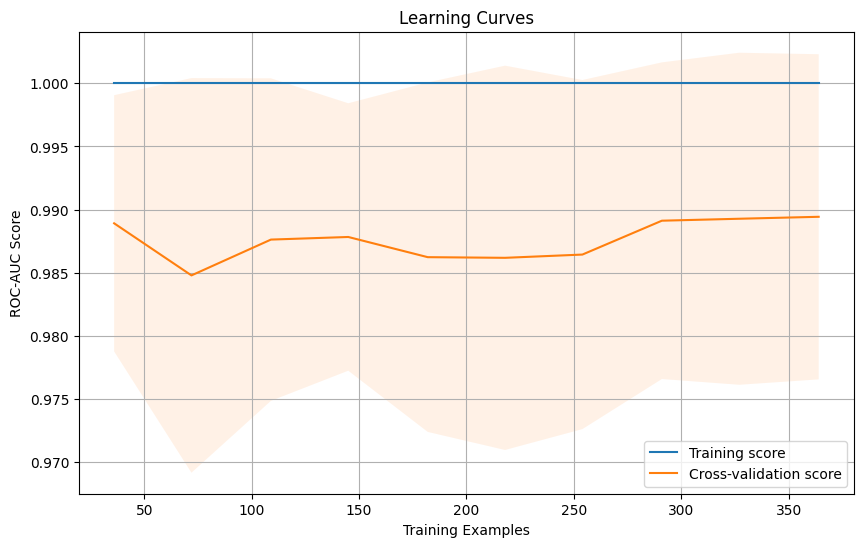

In [39]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(estimator, X, y):
    """Plot learning curves to analyze bias-variance tradeoff"""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc'
    )

    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')

    # Plot standard deviation bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel('Training Examples')
    plt.ylabel('ROC-AUC Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Save plot before showing it
    plt.savefig('../results/learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot learning curves
plot_learning_curves(pipeline, X_train, y_train) # pipeline contains scalar and classifier

This suggests:

Your model might be more complex than necessary and could benefit from more regularisation via:

- Reducing max_depth
- Increasing min_samples_leaf
- Increasing min_samples_split

However, given that:

- CV score is extremely high (>0.98)
- Gap is relatively small (≈0.01)
- You're working with medical data (cancer diagnosis)

This level of overfitting might be acceptable since:

- The model generalises very well despite memorising
- In medical contexts, slightly overfitting to get better performance can be justified
- The high CV score suggests the patterns learned are mostly valid, not just noise

### 2. Handling Class Imbalance

The code addresses class imbalance through class weights, which penalise misclassification of the minority class more heavily.

If you have 100 majority cases and 20 minority cases:
- Majority class weight = 100/100 = 1.0
- Minority class weight = 100/20 = 5.0


These class weights are then used in the RandomForest

In [40]:
# Check class distribution
class_distribution = pd.Series(y_train).value_counts()
print("\nClass Distribution in Training Set:")
print(class_distribution)

# Calculate class weights
class_weights = dict(zip(
    class_distribution.index,
    class_distribution.max() / class_distribution
))

# Create balanced pipeline using class weights
balanced_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight=class_weights,
        n_estimators=200
    ))
])

# Train and evaluate the balanced model
balanced_pipeline.fit(X_train, y_train)
y_pred_balanced = balanced_pipeline.predict(X_test)

print("\nClassification Report (Balanced Model):")
print(classification_report(y_test, y_pred_balanced, target_names=le.classes_))


Class Distribution in Training Set:
0    285
1    170
Name: count, dtype: int64

Classification Report (Balanced Model):
              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



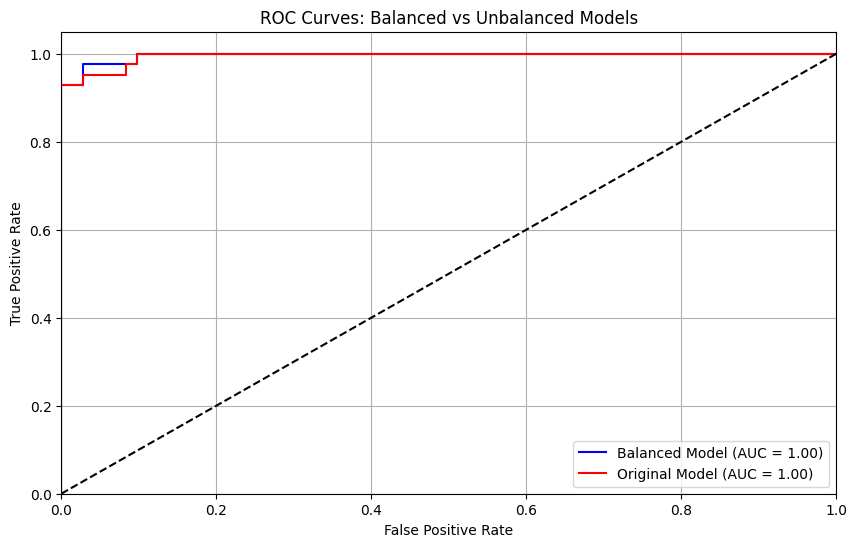

In [41]:
# Compare ROC curves for balanced and unbalanced models
fig, ax = plt.subplots(figsize=(10, 6))

# Plot ROC curve for balanced model
y_pred_proba_balanced = balanced_pipeline.predict_proba(X_test)[:, 1]
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_pred_proba_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

plt.plot(fpr_balanced, tpr_balanced,
         label=f'Balanced Model (AUC = {roc_auc_balanced:.2f})',
         color='blue')

# Plot ROC curve for original model
fpr_original, tpr_original, _ = roc_curve(y_test, y_pred_proba)
roc_auc_original = auc(fpr_original, tpr_original)

plt.plot(fpr_original, tpr_original,
         label=f'Original Model (AUC = {roc_auc_original:.2f})',
         color='red')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Balanced vs Unbalanced Models')
plt.legend(loc="lower right")
plt.grid(True)

# Save plot before showing it
plt.savefig('../results/roc_balanced_vs_unbalanced.png', dpi=300, bbox_inches='tight')
plt.show()

Marginally better performance for the balanced model.

In [42]:
print("First few FPR values:", fpr_balanced[:5])
print("First few TPR values:", tpr_balanced[:5])

First few FPR values: [0.         0.         0.         0.         0.02777778]
First few TPR values: [0.         0.35714286 0.5        0.92857143 0.92857143]


TPR (True Positive Rate) jumps quickly, while FPR (False Positive Rate) stays at 0 for the first few thresholds. This means the model is very confident in its predictions as it can identify many true positives before making any false positive predictions.

### 3. Feature Interaction Analysis

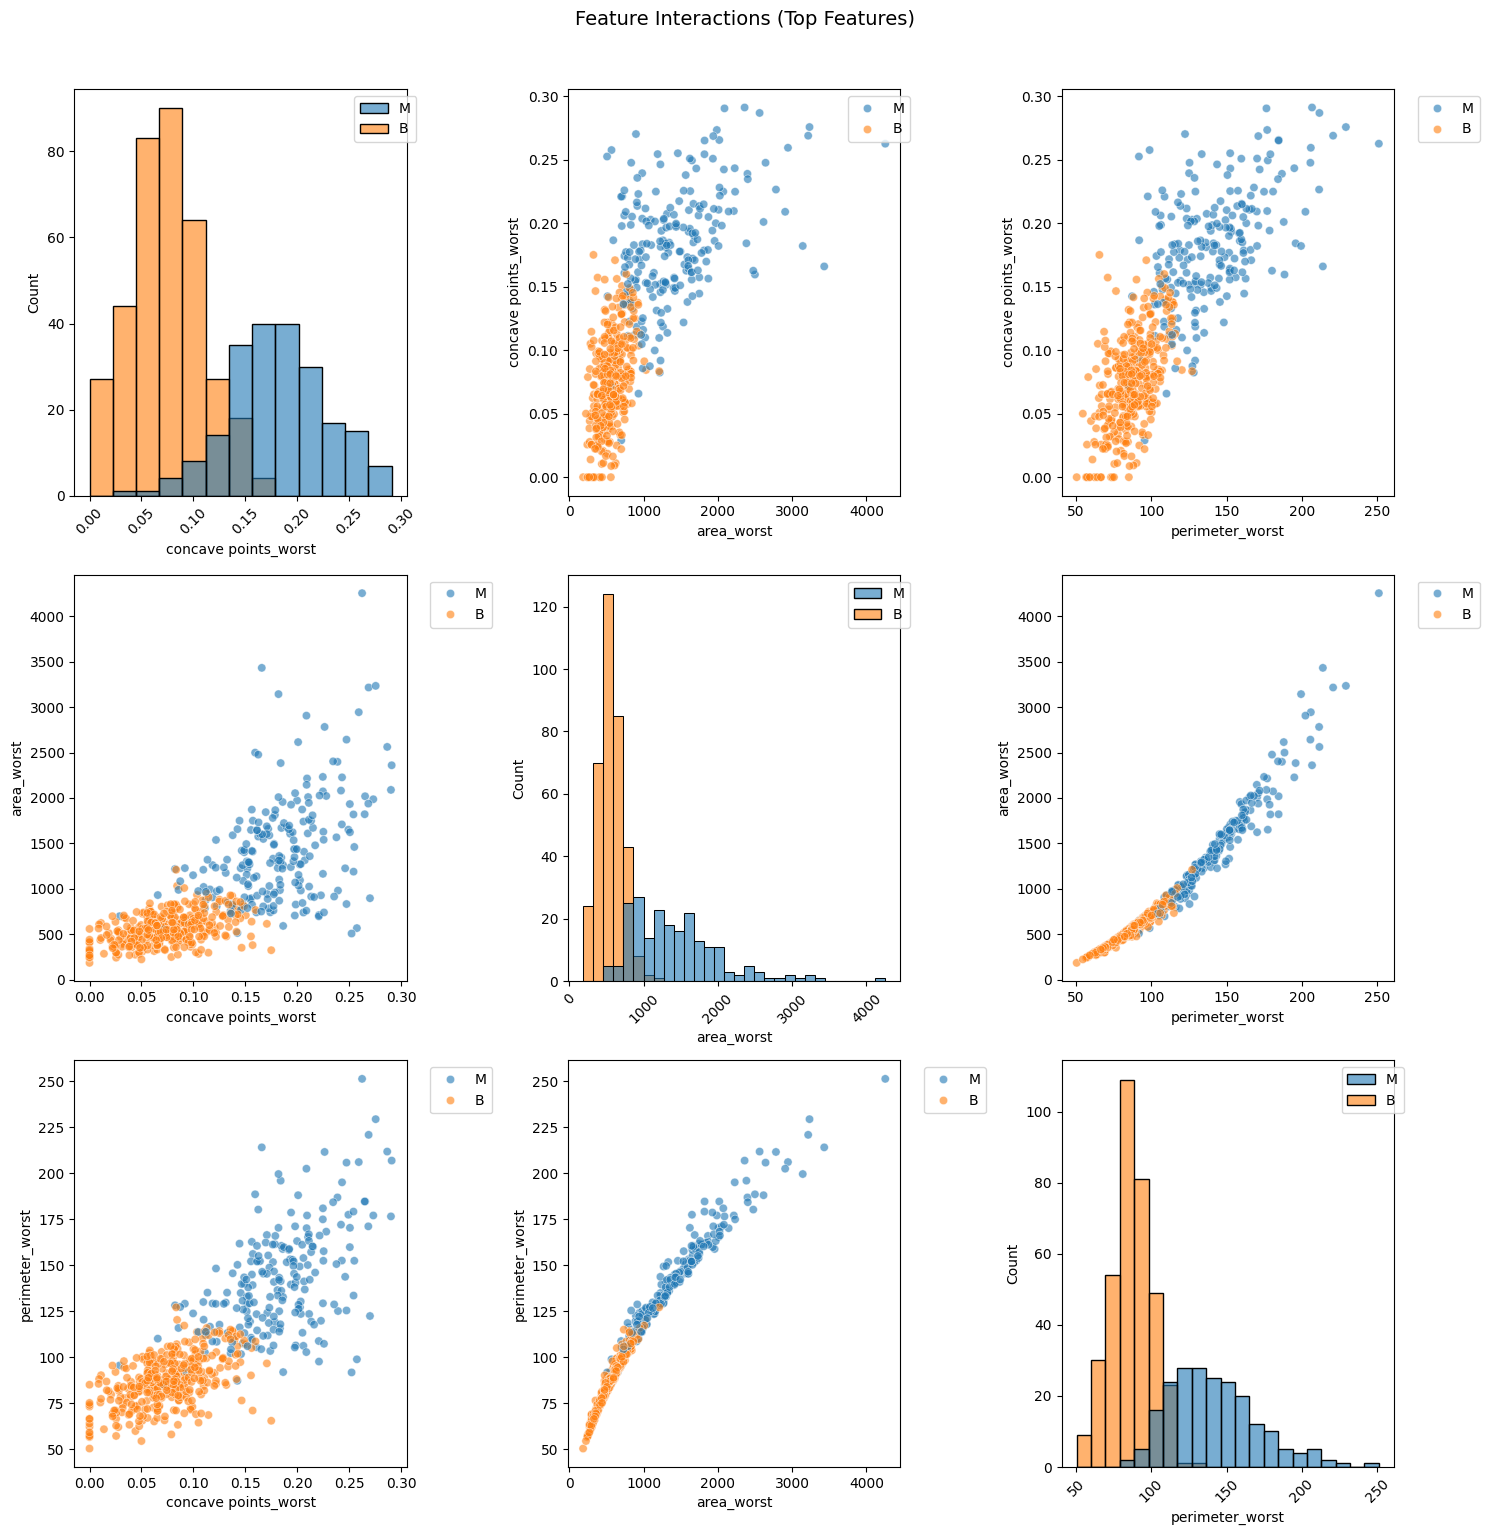

In [43]:
def plot_feature_interactions(model, X, y, le, top_n=3):
    """
    Plot interactions between top features from a model.

    Parameters:
    - model: fitted Pipeline containing RandomForestClassifier
    - X: feature DataFrame
    - y: target labels
    - le: LabelEncoder used for target encoding
    - top_n: number of top features to plot (default=3)
    """
    # Get feature importances and top features
    importances = model.named_steps['classifier'].feature_importances_
    top_features_idx = np.argsort(importances)[-top_n:]
    top_features = X.columns[top_features_idx]

    # Create figure and axes
    fig, axes = plt.subplots(top_n, top_n, figsize=(15, 15))
    fig.suptitle('Feature Interactions (Top Features)', y=1.02, fontsize=14)

    # Plot each feature pair
    for i in range(top_n):
        for j in range(top_n):
            ax = axes[i, j]
            feat_i = top_features[i]
            feat_j = top_features[j]

            # Clear default labels
            ax.set_xlabel('')
            ax.set_ylabel('')

            if i == j:  # Diagonal: histogram
                sns.histplot(
                    data=X,
                    x=feat_i,
                    hue=le.inverse_transform(y),
                    ax=ax,
                    alpha=0.6
                )
                # Rotate labels for better readability
                ax.tick_params(axis='x', rotation=45)
                # Add 'Count' label for histograms
                ax.set_ylabel('Count')

            else:  # Off-diagonal: scatter plot
                sns.scatterplot(
                    data=X,
                    x=feat_j,  # Column (j) determines x-axis
                    y=feat_i,  # Row (i) determines y-axis
                    hue=le.inverse_transform(y),
                    ax=ax,
                    alpha=0.6
                )

            # Add labels only on edges of the grid
            if i == top_n-1:  # Bottom row
                ax.set_xlabel(feat_j, fontsize=10)
            if j == 0:  # Leftmost column
                if i != j:  # Don't override 'Count' label for histograms
                    ax.set_ylabel(feat_i, fontsize=10)

            # Keep legend on all plots
            legend = ax.get_legend()
            if legend is not None:
                legend.set_title('')  # Remove legend title
                legend.set_bbox_to_anchor((1.05, 1))  # Position legend outside plot
                legend.set_frame_on(True)  # Add frame to legend

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_feature_interactions(best_model, X, y, le)

# Save plot before showing it
plt.savefig('../results/feature_interactions.png', dpi=300, bbox_inches='tight')
plt.show()

**Histograms:** Show that these are indeed important features as they show good separation between classes considering the feature by itself.

**Scatter Plots:** Normally, strong correlation between features isn't ideal because it means you're essentially using redundant information (multicollinearity).
However, in this case it's less of a concern because:

The separation between classes happens along the correlation line itself - benign cases cluster in the lower left, malignant in upper right
Even though perimeter_worst and area_worst are naturally correlated (bigger perimeter = bigger area), their combination with concave_points_worst helps reinforce the class separation
Random Forests are also generally robust to correlated features, unlike something like linear regression where it would be more problematic

What matters most here is the clear separation between classes. The correlation actually helps in this case because it shows that malignant tumors consistently show higher values across multiple related measurements, making the pattern more reliable for diagnosis.

### 4. Cross-Validation with Different Metrics

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# Perform cross-validation with multiple metrics
cv_results = cross_validate(best_model, X, y, cv=5, scoring=scoring)

# Print results
print("\nCross-validation results:")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")


Cross-validation results:
accuracy: 0.961 (+/- 0.039)
precision: 0.957 (+/- 0.053)
recall: 0.939 (+/- 0.075)
f1: 0.948 (+/- 0.053)
roc_auc: 0.992 (+/- 0.012)


### 5. Predictions On New Data

In [45]:
def predict_diagnosis(new_data):
    """
    Make predictions on new data using the trained model

    Parameters:
    new_data (pd.DataFrame): DataFrame containing the same features as training data

    Returns:
    tuple: (predictions, prediction_probabilities, prediction_details)
    """
    # Get predictions and all probabilities
    predictions = best_model.predict(new_data)
    probabilities_all = best_model.predict_proba(new_data)

    # Get probability of predicted class for each case
    prediction_probabilities = np.array([prob[pred] for prob, pred in zip(probabilities_all, predictions)])

    # Create detailed prediction info
    prediction_details = pd.DataFrame({
        'Predicted_Diagnosis': le.inverse_transform(predictions),
        'Confidence': prediction_probabilities,
        'Probability_Benign': probabilities_all[:, 0],
        'Probability_Malignant': probabilities_all[:, 1]
    })

    # Add confidence level category
    prediction_details['Confidence_Level'] = pd.cut(
        prediction_details['Confidence'],
        bins=[0, 0.6, 0.8, 1.0],
        labels=['Low', 'Medium', 'High']
    )

    return (
        le.inverse_transform(predictions),
        prediction_probabilities,
        prediction_details
    )

# Example of using the prediction function
new_patient = pd.DataFrame([X_test.iloc[0]])  # Example using first test case
prediction, probability, details = predict_diagnosis(new_patient)

print(f"Predicted diagnosis: {prediction[0]}")
print(f"Confidence in prediction: {probability[0]:.2f} ({details['Confidence_Level'].iloc[0]})")
print("\nDetailed Probabilities:")
print(f"Probability Benign: {details['Probability_Benign'].iloc[0]:.2f}")
print(f"Probability Malignant: {details['Probability_Malignant'].iloc[0]:.2f}")

# Example with multiple cases
multiple_patients = pd.DataFrame(X_test.iloc[0:5])
predictions, probabilities, details = predict_diagnosis(multiple_patients)

print("\nMultiple Patient Predictions:")
display(details)

Predicted diagnosis: B
Confidence in prediction: 0.99 (High)

Detailed Probabilities:
Probability Benign: 0.99
Probability Malignant: 0.01

Multiple Patient Predictions:


,Predicted_Diagnosis,Confidence,Probability_Benign,Probability_Malignant,Confidence_Level
0,B,0.986667,0.986667,0.013333,High
1,M,1.000000,0.000000,1.000000,High
2,B,0.655986,0.655986,0.344014,Medium
3,M,0.571125,0.428875,0.571125,Low
4,B,0.923000,0.923000,0.077000,High


### 6. Model Interpretability with SHAP

Final SHAP values shape for plotting: (50, 30)


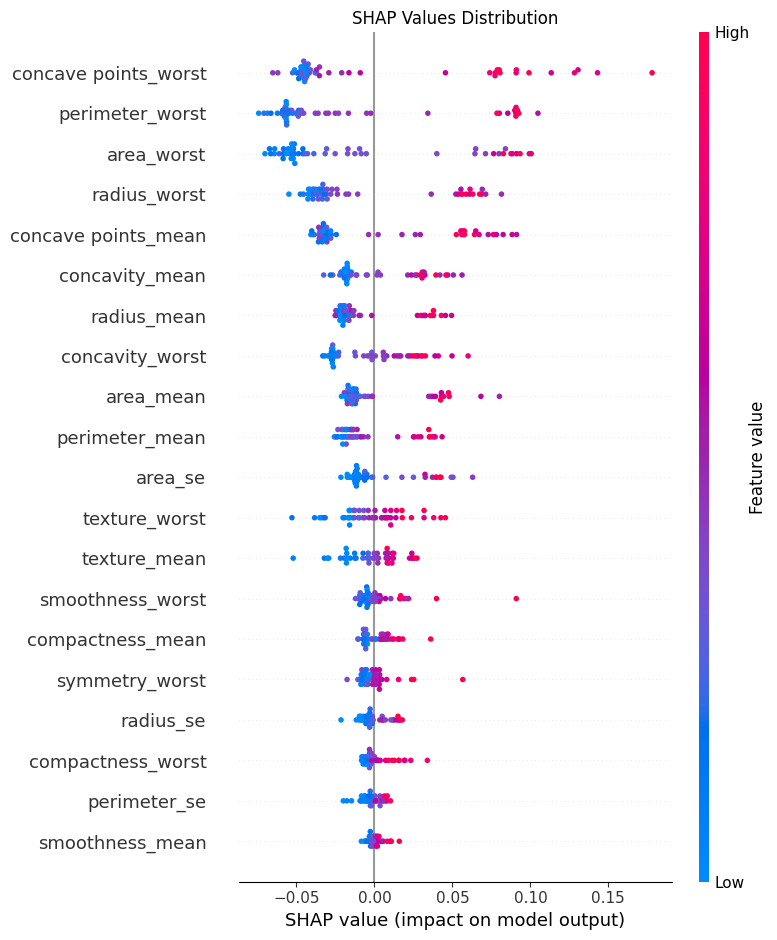


Top 10 most important features based on SHAP values:
                 feature  importance
27  concave points_worst    0.059501
22       perimeter_worst    0.056613
23            area_worst    0.055084
20          radius_worst    0.042462
7    concave points_mean    0.042348
6         concavity_mean    0.022814
0            radius_mean    0.022720
26       concavity_worst    0.021689
3              area_mean    0.021257
2         perimeter_mean    0.020347


<Figure size 1000x600 with 0 Axes>

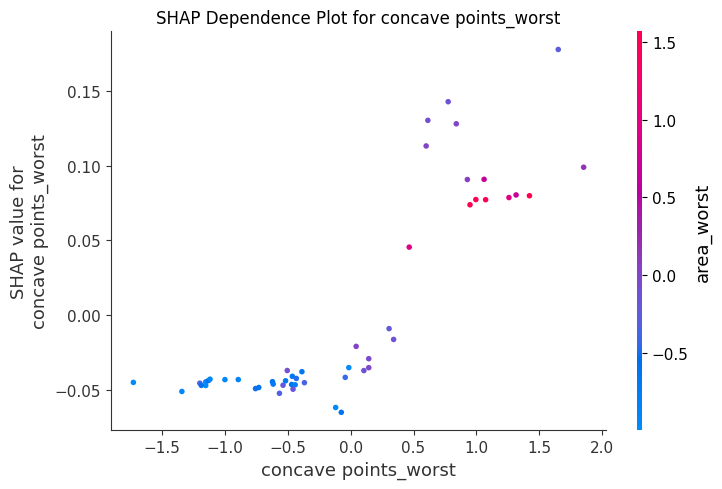

<Figure size 1000x600 with 0 Axes>

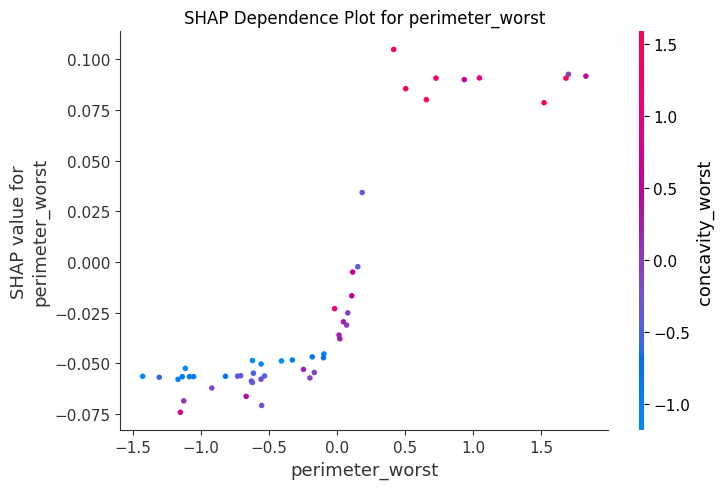

<Figure size 1000x600 with 0 Axes>

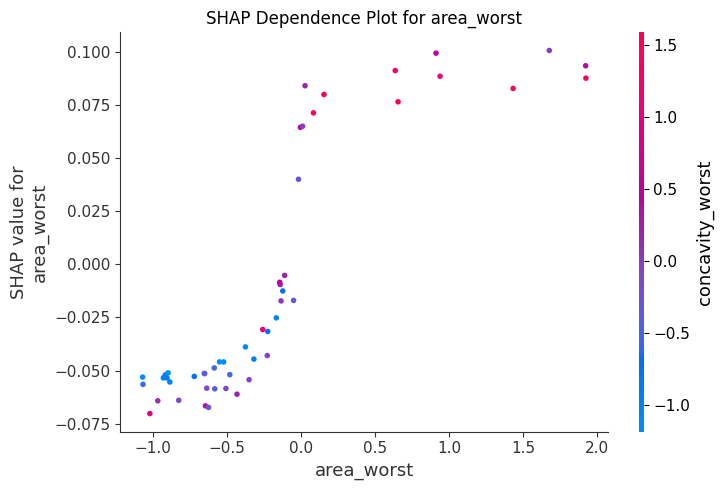

In [46]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_predictions_with_shap(model, X_sample):
    """
    Analyze predictions using SHAP values with proper 3D to 2D conversion

    Parameters:
    model: trained model
    X_sample: sample data to analyze
    """
    # Get the preprocessed data using the pipeline's transform
    X_processed = model.named_steps['scaler'].transform(X_sample)
    X_processed = pd.DataFrame(X_processed, columns=X_sample.columns)

    # Get the Random Forest classifier from the pipeline
    rf_classifier = model.named_steps['classifier']

    # Create SHAP explainer
    explainer = shap.TreeExplainer(rf_classifier)

    try:
        # Get SHAP values and handle 3D array case
        shap_values = explainer.shap_values(X_processed)

        # Check if we have a 3D array and extract values for positive class (class 1)
        if isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
            # Extract values for positive class (index 1)
            shap_values_to_plot = shap_values[:, :, 1]
        elif isinstance(shap_values, list):
            # If we get a list of arrays, use the second one (positive class)
            shap_values_to_plot = shap_values[1]
        else:
            shap_values_to_plot = shap_values

        print(f"Final SHAP values shape for plotting: {shap_values_to_plot.shape}")

        # Generate summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values_to_plot,
            X_processed,
            show=False
        )
        plt.title("SHAP Values Distribution")
        plt.tight_layout()
        
        # Save plot before showing it
        plt.savefig('../results/shap_values_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Calculate feature importance
        mean_abs_shap = np.abs(shap_values_to_plot).mean(0)
        feature_importance = pd.DataFrame({
            'feature': X_sample.columns,
            'importance': mean_abs_shap
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        print("\nTop 10 most important features based on SHAP values:")
        print(feature_importance.head(10))

        # Generate dependence plots for top 3 features
        top_features = feature_importance['feature'].head(3).tolist()
        for feature in top_features:
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature,
                shap_values_to_plot,
                X_processed,
                show=False
            )
            plt.title(f"SHAP Dependence Plot for {feature}")
            plt.tight_layout()
            
            # Save plot before showing it
            plt.savefig(f'../results/shap_dependence_{feature}.png', dpi=300, bbox_inches='tight')
            plt.show()
        

    except Exception as e:
        print(f"Error during SHAP analysis: {str(e)}")
        print("Shapes:")
        print(f"X_processed shape: {X_processed.shape}")
        if 'shap_values' in locals():
            if isinstance(shap_values, list):
                print("SHAP values shapes:", [arr.shape for arr in shap_values])
            else:
                print(f"SHAP values shape: {shap_values.shape}")

# Sample fewer examples to reduce computation time
X_sample = X_test[:50]  # Take smaller sample for SHAP analysis
analyze_predictions_with_shap(best_model, X_sample)

**SHAP Summary Plot (first plot)**: Shows how each feature impacts model predictions. Each dot represents a sample, and the colour indicates feature value (red=high, blue=low). Position on x-axis shows impact on prediction (negative=pushes towards benign, positive=pushes towards malignant). Features are ordered by importance (top=most important).

**Dependence Plots (for top 3 features):** Shows how a single feature's value affects its SHAP value. The points are coloured by another feature that interacts strongly. Strongest interaction means: which other feature most affects the relationship between the main feature and its SHAP values

The key difference from regular feature importance is that SHAP shows:

- Direction of impact (positive/negative)
- Individual sample effects
- Feature interactions
- Non-linear relationships